# MHCI - Peptides Presentation
Author: **Gabriel Schwab**

### Problem
Peptides are short chains of amino acids that can be presented on the surface of cells by MHC proteins.
MHC class I (MHC1) proteins are expressed on the surface of most cells and present peptides to T cells,
allowing the immune system to monitor the cell for signs of infection or abnormal activity. MHC1
proteins are generated by genetic variations in the MHC1 genes, known as alleles, and each individual has
a unique set of MHC1 proteins.

In this notebook, we present our method to build classifiers that predicts if a given peptide will be presented by a
specific MHC1 protein, identified by its allele name.

### Data

The dataset to use is extracted from the training and evaluation data of NetMHCPan4.1, a framework developed in Reynisson et al., 2020, available [here](https://services.healthtech.dtu.dk/services/NetMHCpan-4.1/).

### Outline
This notebook is divided in four sections.

**1. Dataset Analysis**

In this section, we examine the dataset's integrity, explore its statistics, and identify potential issues.

**2. Method Explanation**

Here, we introduce three different approaches to address the problem: two classical machine learning methods and one deep learning method.

**3. Experiment Description**

This section describes a series of experiments to evaluate the performance of our classifiers, highlighting their advantages and drawbacks.

**4. Result Analysis**

Finally, we summarize and provide a comprehensive analysis of the results.

## 1. Dataset Analysis

In [1]:
# If you are working from Google Colab, uncomment this
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Change `ROOT_DIR` variable to point on where your dataset folder is located
ROOT_DIR = ''

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, classification_report, accuracy_score, roc_curve, auc
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

Let's first check the shape and the content of the whole train dataset.

In [5]:
train_data = pd.concat([pd.read_csv(os.path.join(ROOT_DIR, f'netmhcpan41_data/fold_{i}.csv')) for i in range(5)])
test_data = pd.read_csv(os.path.join(ROOT_DIR, 'netmhcpan41_data/test.csv'))
print(train_data.shape)
print(train_data.info())

(3679405, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 3679405 entries, 0 to 735688
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   peptide  object
 1   allele   object
 2   hit      int64 
dtypes: int64(1), object(2)
memory usage: 112.3+ MB
None


Now let's check the integrity of the dataset.

In [6]:
print(train_data.isnull().sum())
print(train_data.isna().sum())

peptide    0
allele     0
hit        0
dtype: int64
peptide    0
allele     0
hit        0
dtype: int64


As we can see, the train dataset is clean, there is non missing values or NaN.
Now we will explore some of its statistics, to better understand the data.

Number of unique peptides: 3584329
Number of unique alleles: 130


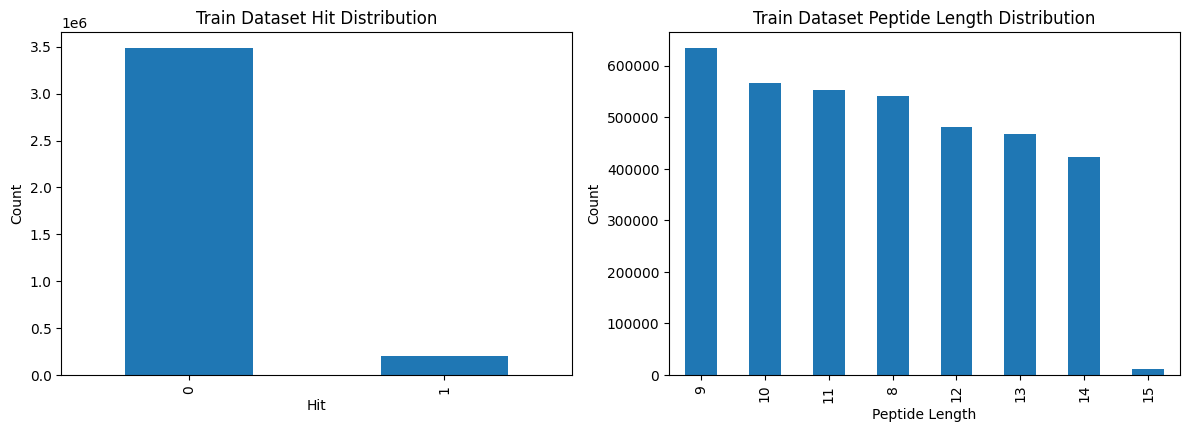

In [17]:
# Number of unique values for peptides and alleles
num_unique_peptides = train_data['peptide'].nunique()
num_unique_alleles = train_data['allele'].nunique()
print(f"Number of unique peptides: {num_unique_peptides}")
print(f"Number of unique alleles: {num_unique_alleles}")

# Analyze the 'hit' column
hit_counts = train_data['hit'].value_counts()

# Peptide length distribution
train_data['peptide_length'] = train_data['peptide'].apply(len)
peptide_length_distribution = train_data['peptide_length'].value_counts()

plt.figure(figsize=(12, 8))

# Hit distribution
plt.subplot(2, 2, 3)
hit_counts.plot(kind='bar')
plt.title('Train Dataset Hit Distribution')
plt.xlabel('Hit')
plt.ylabel('Count')

# Peptide length distribution
plt.subplot(2, 2, 4)
peptide_length_distribution.plot(kind='bar')
plt.title('Train Dataset Peptide Length Distribution')
plt.xlabel('Peptide Length')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

We can observe several important results. Firstly, nearly all the peptides are unique, but there are only 130 distinct alleles. The peptide length is almost uniformly distributed between 9 and 15 amino acids. Lastly, it's crucial to note that the dataset is unbalanced. The distribution of the hit label is 95% for class 0 and 5% for class 1, which can present several challenges when building a classifier.
- Most machine learning algorithms assume balanced data, leading to bias towards the majority class.
- Accuracy is unreliable with imbalanced data, as high accuracy can be achieved by always predicting the majority class, failing to reflect true performance on the minority class.
- Models trained on imbalanced data may overfit to the majority class, resulting in poor generalization and performance on new minority class examples.

There is many techniques to adress unbalanced dataset. On the first part of the dataset we will observe how good perform classical machine learning models without resampling the dataset. We will use metrics such as **precision**, **recall**, **F1-score** or also **ROC-AUC** to evaluate them.

In the second part of this work, we will test these models as well as a Deep Learning model on a undersampled balanced dataset.


## 2. Method Explanation
There is two approaches to predict MHCI presentation based on the peptide and the MHC allele. The first one is to build a specific model for each existing HLAs. The advantage of this approach is that we don't need to encode the allele data. However, this approach takes a long time to train and cannot handle unseen HLAs.

The second approach is to use the sequences of both the peptides and the HLAs to construct a single pan-specific model for an entire class of HLAs as in (Reynisson et al., 2020). As opposed to the first approach, we train only one model that will take an encoding of the HLAs, and will therfore be able to handle unseen alleles. The challenge here is to find the right encoding for HLAs.

In this work, we will use the second approach because the training dataset does not include all existing alleles, and this method allows for better generalization.





### Feature Engineering
#### Peptides
Peptide are represented by a sequence of characters, each one encoding a specific amino acid. Since there is 20 differents amino acids, there is 20 different encoding characters.
The amino acids are categorical data, which means that we need to encode them in order to feed a model. We can use a one hot encoder to perfom this encoding.
As a result we get the following vectors:
- A: [1,0,0,0,...]
- C: [0,1,0,0,...]
- E: [0,0,1,0,...]

We then concatenate all the one hot encoded vector of each amino acid. Since, we observed that there was peptides of different lengths, we chose to encode all of them in a vector of size equal to the maximum peptide length. This allows us to preserve the structure information contain in the sequence.

As a result, we get a feature vector of shape (20*`max_peptide_length`).

We also save the initial peptide as it might be a usefull information for the mdoels.

#### HLA allele
Based on the specification on the [nomenclature of HLA Alleles](https://hla.alleles.org/nomenclature/naming.html), we treat the HLA allele as categorical data. Moreover, we decided distinguish the gene and the subtype of the allele.

There is two ways of handling these categorical data. The first one is to manually encode the data. The second approach is to let the model learn an representation of these data called *embedding*. We will test both approaches.

The training dataset does not include all possible genes or allele subtypes. Therefore, we create a vocabulary based on the genes and subtypes present in the training data. Each unique gene or subtype is assigned an index from 1 to the number of unique values, which will serve as their one-hot encoding. Any unseen values encountered in the test set will be assigned an index of 0.

### Models
We will use 3 different models:

#### Random Forest
It is an ensemble learning method for classification, that constructs a multitude of decision trees at training time. Here are the reason why we choose Random Forest:
- Works well with big datasets and high dimensionality data (which is our case)
- Easily capture non-linear pattern
- Computationally efficient and low training time because each decision-tree can be train in parallel
- Less prone to overfit as it tends to reduce the variance

#### Extreme Gradient Boosting (XGBoost)
XGBoost is also an esemble learning method which is based on gradient boosting. Gradient boosting methods train iteratively a decision tree based on the accuracy of the previous one.
- Well suited for large datasets, more than Random Forest
- Highly performant with very low training time thanks to many optimizations


#### Custom Deep Learning Model
Since the increasing amount of data about MHCI-peptide presentation, artificials neural networks (ANNs) are becoming more and more popular for this type of problem. In the recent years, ANNs were found among the top-performed methods (Luo et al., 2015).

Various neural network architectures are suitable for this problem. We opted to develop our own convolutional neural network (CNN) architecture. CNNs are effective for this type of problem due to their capacity of learning spatial structures, which is beneficial for capturing peptide structure information. Additionally, CNNs are relatively simple architectures and easy to implement.

Our architecture is based on DeepSeqPan (Liu et al., 2019) and the DCNN from Han et al., 2017.

It consist of 3 modules. The first one, `PeptideEncoder` use a CNN to encode petpide data and capture its spatial structure. The second one, `HLAEncoder` is a multi layer perceptron (MLP) that learn an embedding of the HLAs. Finally, we concatenate them in the `NetMHC` and pass it throughout a MLP.

In [18]:
amino_acids = 'ACEDGFIHKMLNQPSRTWVY'

# mapping a unique integer to each amino acid
aa2int = dict((c, i) for i, c in enumerate(amino_acids))

def one_hot_encode_peptide(peptide, max_peptide_length):
    """One-hot encodes a peptide sequence

    Args:
        peptide (str): The peptide sequence to encode.
        max_peptide_length (int): Maximum peptide length

    Returns:
        numpy.ndarray: One-hot encoded matrix of shape (max_peptide_length * len(amino_acids)).
    """
    # Encode each character in the peptide
    integer_encoded = [aa2int.get(char, len(amino_acids)) for char in peptide]

    # Pad sequence if shorter than max_peptide_length
    if len(integer_encoded) < max_peptide_length:
        integer_encoded += [len(amino_acids)] * (max_peptide_length - len(integer_encoded))
    elif len(integer_encoded) > max_peptide_length:
        integer_encoded = integer_encoded[:max_peptide_length]

    # One-hot encoding
    onehot_encoded = np.zeros((max_peptide_length, len(amino_acids)), dtype=np.int8)

    for i, value in enumerate(integer_encoded):
        if value < len(amino_acids):
            onehot_encoded[i, value] = 1

    return onehot_encoded

In [19]:
def build_hla_gene_vocabulary(alleles):
    '''Build a vocabulary of each unique gene encountered

    Args:
        alleles (pd.Series): Serie of string of the pattern 'Yxx:xx',
        where Y is a char representig the gene and each x a digit representig the subtype

    Returns:
        dict: Dictionary of unique genes
    '''
    splitted_alleles = alleles.str.split('-', expand=True)[1]
    hla_genes = splitted_alleles.str[0]
    # +1 to reserve 0 index for the unseen data
    vocabulary = {gene: i+1 for i, gene in enumerate(hla_genes.unique())}
    return vocabulary

def build_hla_subtype_vocabulary(alleles):
    '''
    Build a vocabulary of each unique subtype encountered

    Args:
        alleles (pd.Series): Serie of string of the pattern 'Yxx:xx',
        where Y is a char representig the gene and each x a digit representig the subtype

    Returns:
        dict: Dictionary of unique subtype
    '''
    splitted_alleles = alleles.str.split('-', expand=True)[1]
    subtypes = splitted_alleles.str[1:]
    # +1 to reserve 0 index for the unseen data
    vocabulary = {subtype: i+1 for i, subtype in enumerate(subtypes.unique())}
    return vocabulary

In [20]:
def encode_data(data, gene_vocab, subtype_vocab):
    '''Encode the data about MHC-Peptide presentation

    Args:
        data (pd.DataFrame): The original data
        gene_vocab (dict): gene vocabulary
        subtype_vocab (dict): subtype vocabulary

    Returns:
        pd.DataFrame: The encoded data
    '''
    encoded_data = pd.DataFrame()

    # Extract gene and subtype from HLA allele
    splitted_allele = data['allele'].str.split('-', expand=True)[1]
    gene = splitted_allele.str[0]
    subtype = splitted_allele.str[1:]

    # Build encoded DataFrame
    encoded_data = pd.DataFrame()
    encoded_data['encoded_peptide'] = data['peptide'].apply(lambda x: one_hot_encode_peptide(x, 15).flatten())
    encoded_data['peptide_length'] = data['peptide'].apply(lambda x: len(x))
    encoded_data['encoded_gene'] = gene.apply(lambda x: gene_vocab.get(x, 0))
    encoded_data['encoded_subtype'] = subtype.apply(lambda x: subtype_vocab.get(x, 0))
    encoded_data['hit'] = data['hit']

    return encoded_data


In [21]:
def encoded_data2numpy(train_data_encoded, test_data_encoded):
    '''Convert encoded data to numpy array

    Args:
        train_data_encoded (pd.DataFrame): Encoded training data
        test_data_encoded (pd.DataFrame): Encoded test data

    Returns:
        np.ndarray: X_train, X_test, y_train, y_test
    '''
    X_train = np.hstack([
        np.stack(train_data_encoded['encoded_peptide'].to_numpy()),
        train_data_encoded['peptide_length'].to_numpy().reshape(-1,1),
        train_data_encoded['encoded_gene'].to_numpy().reshape(-1,1),
        train_data_encoded['encoded_subtype'].to_numpy().reshape(-1,1)
    ])

    X_test = np.hstack([
        np.stack(test_data_encoded['encoded_peptide'].to_numpy()),
        test_data_encoded['peptide_length'].to_numpy().reshape(-1,1),
        test_data_encoded['encoded_gene'].to_numpy().reshape(-1,1),
        test_data_encoded['encoded_subtype'].to_numpy().reshape(-1,1)
    ])

    y_train = train_data_encoded['hit'].to_numpy()
    y_test  = test_data_encoded['hit'].to_numpy()

    return X_train, X_test, y_train, y_test

In [22]:
def undersample_balance_data(data):
    '''Balance the data by undersampling it such that both classes are evenly distributed

    Args:
        data (pd.DataFrame): Data containing the 'hit' column

    Returns:
        pd.DataFrame: balanced sample of the data
    '''
    class_0 = data[data['hit'] == 0]
    class_1 = data[data['hit'] == 1]

    n_samples = min(len(class_0), len(class_1))

    class_0_balanced = class_0.sample(n_samples, random_state=42)
    class_1_balanced = class_1.sample(n_samples, random_state=42)

    data_balanced = pd.concat([class_0_balanced, class_1_balanced], ignore_index=True)
    return data_balanced

In [23]:
models = {
    'random_forest': RandomForestClassifier(random_state=42),
    'xg_boost': xgb.XGBClassifier(random_state=42)
}

def train_models(models_dict, X_train, y_train):
    for name, model in models_dict.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        print(f'{name} trained in {end_time - start_time} seconds')

def test_models(models_dict, X_test, y_test):
    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Test Accuracy: {test_accuracy}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("ROC Curve")
        ax = plt.gca()
        rfc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
        plt.show()

In [24]:
class PeptideEncoder(nn.Module):
    def __init__(self):
        super(PeptideEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(1)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.leaky_relu(out)
        return out

class HLAEncoder(nn.Module):
    def __init__(
        self,
        gene_vocab_size,
        gene_embed_size,
        subtype_vocab_size,
        subtype_embed_size
    ):
        super(HLAEncoder, self).__init__()
        self.gene_embedding = nn.Embedding(gene_vocab_size, gene_embed_size)
        self.subtype_embedding = nn.Embedding(subtype_vocab_size, subtype_embed_size)
        self.fc1 = nn.Linear(gene_embed_size + subtype_embed_size, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 212)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, gene_idx, subtype_idx):
        gene_embed = self.gene_embedding(gene_idx).squeeze(1)
        subtype_embed = self.subtype_embedding(subtype_idx).squeeze(1)
        combined = torch.cat((gene_embed, subtype_embed), dim=1)

        out = self.fc1(combined)
        out = self.leaky_relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.leaky_relu(out)
        return out

class NetMHC(nn.Module):
    def __init__(
        self,
        gene_vocab_size,
        gene_embed_size,
        subtype_vocab_size,
        subtype_embed_size
    ):
        super(NetMHC, self).__init__()
        self.peptide_encoder = PeptideEncoder()
        self.hla_encoder = HLAEncoder(gene_vocab_size, gene_embed_size, subtype_vocab_size, subtype_embed_size)
        self.fc1 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 1)
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        peptides, genes, subtypes = x
        peptide_encoded = self.peptide_encoder(peptides)
        peptide_encoded = peptide_encoded.view(-1, 300)
        hla_encoded = self.hla_encoder(genes, subtypes)
        combined = torch.cat((peptide_encoded, hla_encoded), dim=1)

        out = self.fc1(combined)
        out = self.leaky_relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

In [25]:
class MHCDataset(Dataset):
    def __init__(self, features, labels):

        self.gene_features = features['encoded_gene'].to_numpy().reshape(-1, 1)
        self.subtype_features = features['encoded_gene'].to_numpy().reshape(-1, 1)
        self.peptide_features = np.stack(features['encoded_peptide'].to_numpy()).reshape(-1, 1, 15, 20)

        self.labels = labels.to_numpy()

        assert len(self.peptide_features) == len(self.gene_features) == len(self.subtype_features)== len(self.labels)

    def __len__(self):
        return len(self.peptide_features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.peptide_features[idx], dtype=torch.float32),
            torch.tensor(self.gene_features[idx], dtype=torch.long),
            torch.tensor(self.subtype_features[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

## 3. Experiment Description

### Datasets

Given the fact that we are dealing with unbalanced data, we train the Random Forest and XGBoost models on two distinct datasets. The first dataset is a random sample from the full training set, which remains unbalanced. The second dataset is a balanced subset of the full dataset. Both datasets are of equal size.

Regarding our neural network model, we will not train it on the unbalanced dataset because preliminary experiments showed that the loss function was too low, preventing the model from training effectively.



### Metrics
We will use the following metrics to evaluate our models:


In the following, $tp$ denote true positive, $fp$ denote false positive, $tn$ denote true negative and $fn$ denote false negative.

- **precision**: $\frac{tp}{tp+fp}$ (How accurate the model is among the predicted positives)
- **recall**: $\frac{tp}{tp+fn}$ (How the model correctly identify True Positives)
- **f1-score**: $2*\frac{precision*recall}{precision+recall}$ (Balance between precision and recall)
- **ROC AUC**:  Area Under the Receiver Operating Characteristic Curve (How well the model distinguishes between positive and negative classes)


In [26]:
# Get a sample of the full dataset (we take the same size of the balanced dataset we will use afterwards)
train_data_sample = train_data.sample(90832, random_state=42)

# Drop the '*' character to align with the test data format
train_data_sample['allele'] = train_data_sample['allele'].str.replace('*', '', regex=False)

gene_vocab = build_hla_gene_vocabulary(train_data_sample['allele'])
subtype_vocab = build_hla_subtype_vocabulary(train_data_sample['allele'])

train_data_encoded = encode_data(train_data_sample, gene_vocab, subtype_vocab)
test_data_encoded = encode_data(test_data, gene_vocab, subtype_vocab)

X_train, X_test, y_train, y_test = encoded_data2numpy(train_data_encoded, test_data_encoded)

random_forest trained in 24.304145097732544 seconds
xg_boost trained in 4.035407781600952 seconds
random_forest Test Accuracy: 0.9554305330812215
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    900725
           1       0.85      0.09      0.16     45416

    accuracy                           0.96    946141
   macro avg       0.90      0.54      0.57    946141
weighted avg       0.95      0.96      0.94    946141

ROC Curve


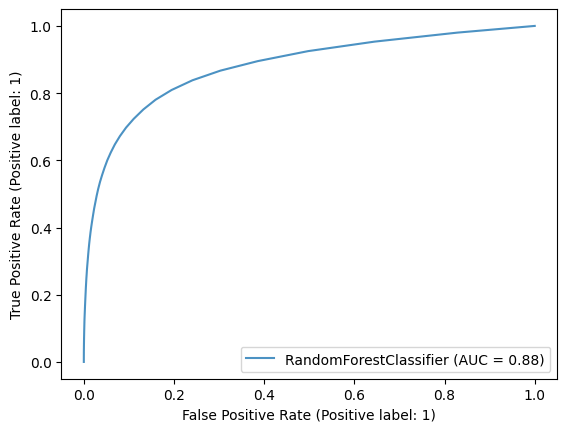

xg_boost Test Accuracy: 0.9596286388603813
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    900725
           1       0.71      0.27      0.39     45416

    accuracy                           0.96    946141
   macro avg       0.84      0.63      0.68    946141
weighted avg       0.95      0.96      0.95    946141

ROC Curve


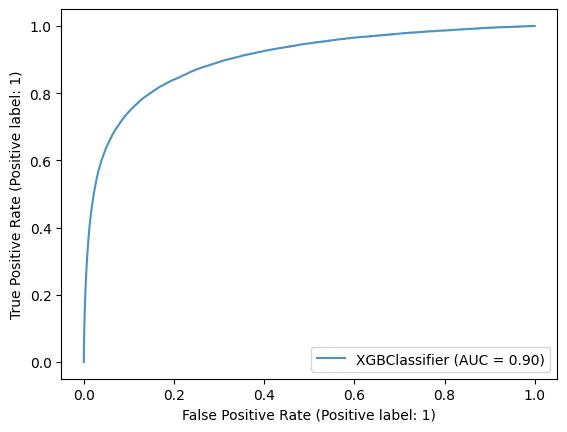

In [27]:
train_models(models, X_train, y_train)
test_models(models, X_test, y_test)

In [28]:
# Get a balanced sample of the full dataset
train_data_sample = undersample_balance_data(train_data)

# Drop the '*' character to align with the test data format
train_data_sample['allele'] = train_data_sample['allele'].str.replace('*', '', regex=False)

gene_vocab = build_hla_gene_vocabulary(train_data_sample['allele'])
subtype_vocab = build_hla_subtype_vocabulary(train_data_sample['allele'])

train_data_encoded = encode_data(train_data_sample, gene_vocab, subtype_vocab)
test_data_encoded = encode_data(test_data, gene_vocab, subtype_vocab)

X_train, X_test, y_train, y_test = encoded_data2numpy(train_data_encoded, test_data_encoded)

random_forest trained in 184.6155140399933 seconds
xg_boost trained in 19.85626196861267 seconds
random_forest Test Accuracy: 0.9324138791152693
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    900725
           1       0.39      0.74      0.51     45416

    accuracy                           0.93    946141
   macro avg       0.69      0.84      0.74    946141
weighted avg       0.96      0.93      0.94    946141

ROC Curve


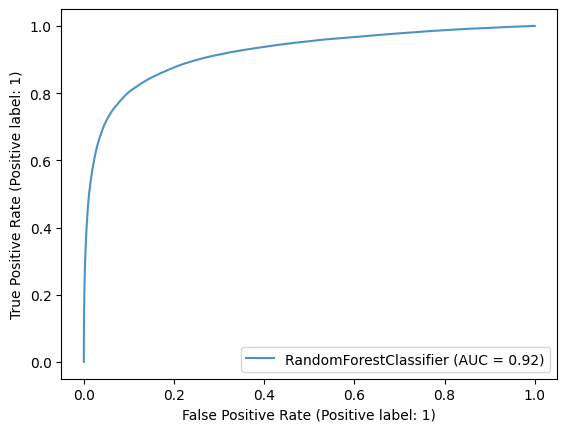

xg_boost Test Accuracy: 0.8932844047557393
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94    900725
           1       0.28      0.78      0.41     45416

    accuracy                           0.89    946141
   macro avg       0.63      0.84      0.68    946141
weighted avg       0.95      0.89      0.92    946141

ROC Curve


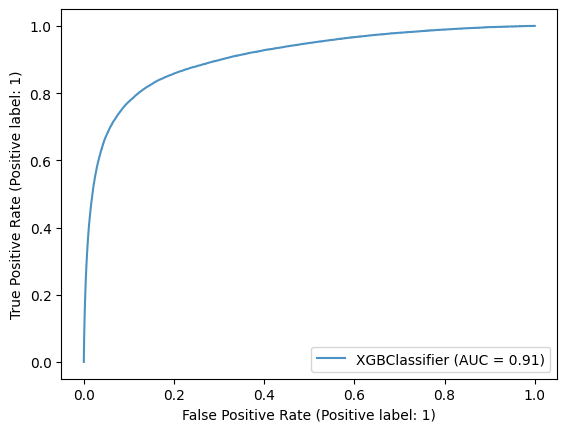

In [29]:
train_models(models, X_train, y_train)
test_models(models, X_test, y_test)

In [32]:
# Training Hyperparameters
batch_size = 32
learning_rate = 0.001
n_epochs = 20

# Extract training and validation sets
features_train, features_val, labels_train, labels_val = train_test_split(train_data_encoded, train_data_sample['hit'], test_size=0.2, random_state=42)

train_set = MHCDataset(features_train, labels_train)
val_set = MHCDataset(features_val, labels_val)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [33]:
# Get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# +1 to handle unseen data
model = NetMHC(len(gene_vocab)+1, 3, len(subtype_vocab)+1, 150).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# NetMHC Training
train_loss_hist, train_acc_hist = [], []
val_loss_hist, val_acc_hist = [], []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    train_correct = 0
    train_loss = 0.0

    for peptide_features, gene_features, subtype_features, labels in \
        tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} - Training', leave=False):

        peptide_features = peptide_features.to(device)
        gene_features = gene_features.to(device)
        subtype_features = subtype_features.to(device)
        labels = labels.to(device)

        x = (peptide_features, gene_features, subtype_features)
        y = labels.unsqueeze(1)

        optimizer.zero_grad()

        # Forward pass
        logit = model.forward(x)
        loss = criterion(logit, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_correct += (logit.round() == y).sum().item()
        train_loss += loss.item()

    train_avg_loss = train_loss / len(train_set)
    train_loss_hist.append(train_avg_loss)
    train_avg_acc = train_correct / len(train_set)
    train_acc_hist.append(train_avg_acc)


    # Eval
    model.eval()
    val_correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for peptide_features, gene_features, subtype_features, labels in \
            tqdm(val_loader, desc=f'Epoch {epoch}/{n_epochs} - Validation', leave=False):

            peptide_features = peptide_features.to(device)
            gene_features = gene_features.to(device)
            subtype_features = subtype_features.to(device)
            labels = labels.to(device)

            x = (peptide_features, gene_features, subtype_features)
            y = labels.unsqueeze(1)

            # Forward pass
            logit = model.forward(x)
            loss = criterion(logit, y)

            val_correct += (logit.round() == y).sum().item()
            val_loss += loss.item()

    val_avg_loss = val_loss / len(val_set)
    val_loss_hist.append(val_avg_loss)
    val_avg_acc = val_correct / len(val_set)
    val_acc_hist.append(val_avg_acc)


    print(f'  train_loss: {train_avg_loss:.2f}, train_accuracy: {train_avg_acc:.2f}' \
          f'  val_loss: {val_avg_loss:.2f}, val_accuracy: {val_avg_acc:.2f}')

# Save the model
torch.save(model.state_dict(), os.path.join(ROOT_DIR, 'netmhc_balanced.pth'))

end_time = time.time()
print(f'NetMHC Training time: {end_time - start_time} seconds')

  train_loss: 0.01, train_accuracy: 0.88  val_loss: 0.01, val_accuracy: 0.91


  train_loss: 0.01, train_accuracy: 0.91  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.91  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.91  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.91  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.92


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93


  train_loss: 0.01, train_accuracy: 0.92  val_loss: 0.01, val_accuracy: 0.93
NetMHC Training time: 1099.5886719226837 seconds


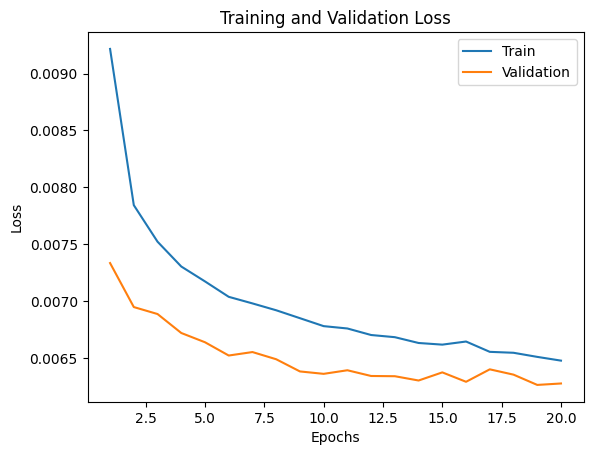

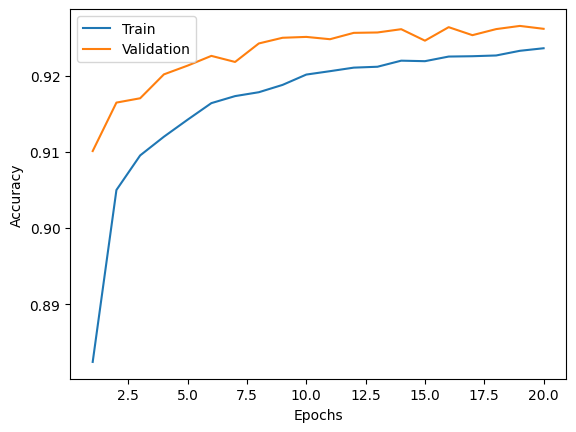

In [34]:
epochs = range(1, n_epochs + 1)

# Plot the loss graph
plt.figure()
plt.plot(epochs, train_loss_hist, label='Train')
plt.plot(epochs, val_loss_hist, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Plot the accuracy graph
plt.figure()
plt.plot(epochs, train_acc_hist, label='Train')
plt.plot(epochs, val_acc_hist, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
test_set = MHCDataset(test_data_encoded, test_data_encoded['hit'])
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model.eval()

y_probas = []

with torch.no_grad():
    for peptide_features, gene_features, subtype_features, _ in test_loader:
      peptide_features = peptide_features.to(device)
      gene_features = gene_features.to(device)
      subtype_features = subtype_features.to(device)

      x = (peptide_features, gene_features, subtype_features)

      # Forward pass
      logit = model(x)

      y_probas.extend(logit.cpu().numpy())

NetMHC Test Accuracy: 0.9119370157302136
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    900725
           1       0.33      0.80      0.47     45416

    accuracy                           0.91    946141
   macro avg       0.66      0.86      0.71    946141
weighted avg       0.96      0.91      0.93    946141

ROC Curve


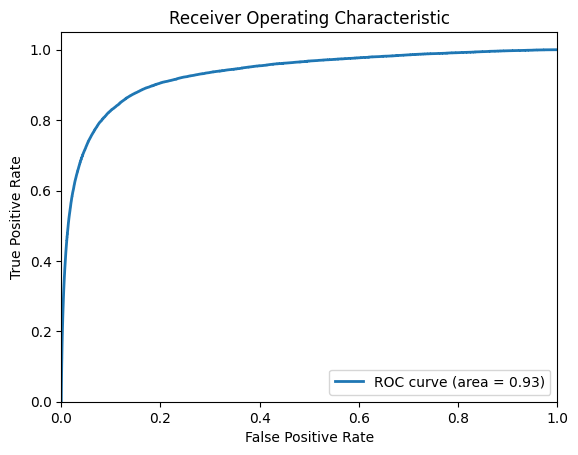

In [37]:
test_accuracy = accuracy_score(y_test, np.round(y_probas))
print(f"NetMHC Test Accuracy: {test_accuracy}")
print("Classification Report:")
print(classification_report(y_test, np.round(y_probas)))
print("ROC Curve")
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_probas)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Result Analysis

### Unbalanced Dataset
First, the **training time** is 24s for Random Forest and 4s for XGBoost, so XGBoost is training 6 times faster.

Then, we notice that **precision**, **recall** and **f1-score** are close to 1 for the negative class ('0' label) but significantly lower for the positive class ('1' label). This indicates that the model is really good at predicting true negative but struggle to predict the true positive. The imbalance in the dataset could be a reason for this issue.

Because the metrics are the same for both model regarding the '0' class, we summarize the metrics **only for '1' class** in the following table:

|               | precision | recall | f1-score | ROC AUC |
| --------------| --------- | ------ | -------- | ------- |
| Random Forest | 0.85      | 0.09   | 0.16     | 0.88    |
| XGBoost       | 0.71      | 0.27   | 0.39     | 0.90    |

As a result, wee see that the XGBoost classifier is performing better than the Random Forest classifier on the Unbalanced Dataset, as well as being faster to train.

### Balanced Dataset

First, the training time for Random Forest is 185 seconds, while for XGBoost it is 20 seconds, making XGBoost nearly 10 times faster than Random Forest. NetMHC takes 1100 seconds, which is significantly longer.

Then, the three models have almost the same metrics for the negative class. Although the metrics for the positive class remain lower than those for the negative class, they are significantly improved compared to the unbalanced dataset. This indicates that dataset balance plays a crucial role.

The following table summarize the metrics for the positive class:

|               | precision | recall | f1-score | ROC AUC |
| --------------| --------- | ------ | -------- | ------- |
| Random Forest | 0.39      | 0.74   | 0.51     | 0.92    |
| XGBoost       | 0.28      | 0.78   | 0.41     | 0.91    |
| NetMHC        | 0.33      | 0.80   | 0.47     | 0.93    |


For Random Forest and XGBoost, precision is halved with the balanced dataset, but recall is significantly higher. Overall, the F1-score and ROC AUC are slightly improved with the balanced dataset. The top-performing models are either NetMHC or Random Forest, depending on the metric of interest.




### Which dataset to choose ?

Given the results, we recognize a precision-recall trade-off. If you want to focus on the **correctness** of positive predictions, then you should train your model on the raw dataset or a sample of it. If you want to focus on capturing **all relevant instances**, then you should train your models on a balanced dataset.

### Which model to choose ?

Overall, the model with the highest ROC AUC is the NetMHC model trained on the balanced dataset. Along with the Random Forest model trained on the balanced dataset, these are the best-performing models when considering all metrics.

Nevertheless, the choice of model ultimately depends on the specific use case.

### Further improvements



1.   **Adressing class imbalance**:

     Class imbalance significantly affects model performance. In this work, we address this issue by undersampling the dataset, although this approach results in data loss. We could oversample the dataset using synthetic data. However, this method must be used cautiously, especially since it is a biological application.

2.  **Feature engineering:**
    
    The way we encoded the petpide sequence only preserve information about its spatial structure/sequence. There is other methods in the litterature such as BLOSUM matrix to add some information about amino acid similarity.
    Regarding the HLA allele encoding, other methods than one hot encoding exists, such as mapping HLA to an amino acid pseudo sequence.

3.  **Model**:

    We focused only on 3 different models. We could invesigate further their hyperparameters tuning. Other NNs architecutre are used in the state-of-the-art such as RNNs or attention-based NNs (Kalemati et al., 2023) to leverage the sequence information contained in the data.


## References
- Reynisson, B., Alvarez, B., Paul, S., Peters, B., & Nielsen, M. (2020). NetMHCpan-4.1 and NetMHCIIpan-4.0: improved predictions of MHC antigen presentation by concurrent motif deconvolution and integration of MS MHC eluted ligand data. In Nucleic Acids Research (Vol. 48, Issue W1, pp. W449–W454). Oxford University Press (OUP). https://doi.org/10.1093/nar/gkaa379

- Luo, H., Ye, H., Ng, H. W., Shi, L., Tong, W., Mendrick, D. L., & Hong, H. (2015). Machine Learning Methods for Predicting HLA-Peptide Binding Activity. In Bioinformatics and Biology Insights (Vol. 9s3, p. BBI.S29466). SAGE Publications. https://doi.org/10.4137/bbi.s29466

- Liu, Z., Cui, Y., Xiong, Z., Nasiri, A., Zhang, A., & Hu, J. (2019). DeepSeqPan, a novel deep convolutional neural network model for pan-specific class I HLA-peptide binding affinity prediction. In Scientific Reports (Vol. 9, Issue 1). Springer Science and Business Media LLC. https://doi.org/10.1038/s41598-018-37214-1

- Han, Y., & Kim, D. (2017). Deep convolutional neural networks for pan-specific peptide-MHC class I binding prediction. In BMC Bioinformatics (Vol. 18, Issue 1). Springer Science and Business Media LLC. https://doi.org/10.1186/s12859-017-1997-x

- Kalemati, M., Darvishi, S. & Koohi, S. CapsNet-MHC predicts peptide-MHC class I binding based on capsule neural networks. Commun Biol 6, 492 (2023). https://doi.org/10.1038/s42003-023-04867-2